## Import relevant libraries 

In [5]:
import warnings
warnings.filterwarnings("ignore")
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Flatten, Conv2D, BatchNormalization, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

## Apply DenseNet121 Transfer Learning with Image Augmentation

In [6]:
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator 
# Reference: https://stackoverflow.com/questions/53037510/can-flow-from-directory-get-train-and-validation-data-from-the-same-directory-in

# generate batches of tensor image data with real-time data augmentation

datagen=ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator = datagen.flow_from_directory(
    "/OCT2017 /train",
    target_size = (224, 224),
    batch_size=32,
    class_mode = "categorical",
    subset="training")

validation_generator = datagen.flow_from_directory(
    "/OCT2017 /train",
    target_size = (224, 224),
    batch_size=32,
    class_mode = "categorical",
    subset="validation")

Found 66788 images belonging to 4 classes.
Found 16696 images belonging to 4 classes.


In [7]:
tf.keras.backend.clear_session()

In [8]:
# Reference: https://keras.io/api/applications/densenet/
densenet121_model = DenseNet121(include_top=False,weights="imagenet",pooling="max",input_shape=(224,224,3))

29097984/29084464 [==============================] - 0s 0us/step


In [ ]:
for layer in densenet121_model.layers[:3]:
    layer.trainable = False

In [ ]:
densenet121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Reference: https://keras.io/api/layers/regularization_layers/dropout/
# Reference: https://keras.io/api/layers/core_layers/dense/
# Reference: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Reference: https://keras.io/api/layers/regularization_layers/dropout/

# Dropout Layer
dropout = Dropout(rate=0.4)(densenet121_model.output)

# Dense Layer
Output_Layer = Dense(4, activation="softmax")(dropout)

# Creating a model
model5 = Model(inputs=densenet121_model.input,outputs=Output_Layer)

In [ ]:
model5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1)

# Creating model5_with_augmentation_save folder before running the code.
filepath="model5_with_augmentation_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')

# Callbacks
optimizer = tf.keras.optimizers.Adam()
model5.compile(optimizer=optimizer,loss="categorical_crossentropy",metrics=["accuracy"])

# Creating a list with all the callbacks we want
callback_list = [earlystop, checkpoint]

train_samples = 66788
validation_samples = 16696
batch_size = 32
model5.fit(train_generator, validation_data= validation_generator, steps_per_epoch=train_samples//batch_size, callbacks=callback_list, epochs=50)

Epoch 1/50
2087/2087 [==============================] - ETA: 0s - loss: 0.4993 - accuracy: 0.8809
Epoch 1: val_accuracy improved from -inf to 0.92022, saving model to model5_with_augmentation_save/weights-01-0.9202.hdf5
2087/2087 [==============================] - 1283s 603ms/step - loss: 0.4993 - accuracy: 0.8809 - val_loss: 0.2834 - val_accuracy: 0.9202
Epoch 2/50
2087/2087 [==============================] - ETA: 0s - loss: 0.4157 - accuracy: 0.8853
Epoch 2: val_accuracy did not improve from 0.92022
2087/2087 [==============================] - 1139s 546ms/step - loss: 0.4157 - accuracy: 0.8853 - val_loss: 0.4088 - val_accuracy: 0.9153
Epoch 3/50
2087/2087 [==============================] - ETA: 0s - loss: 0.2321 - accuracy: 0.9235
Epoch 3: val_accuracy improved from 0.92022 to 0.93412, saving model to model5_with_augmentation_save/weights-03-0.9341.hdf5
2087/2087 [==============================] - 1135s 544ms/step - loss: 0.2321 - accuracy: 0.9235 - val_loss: 0.2122 - val_accuracy: 0

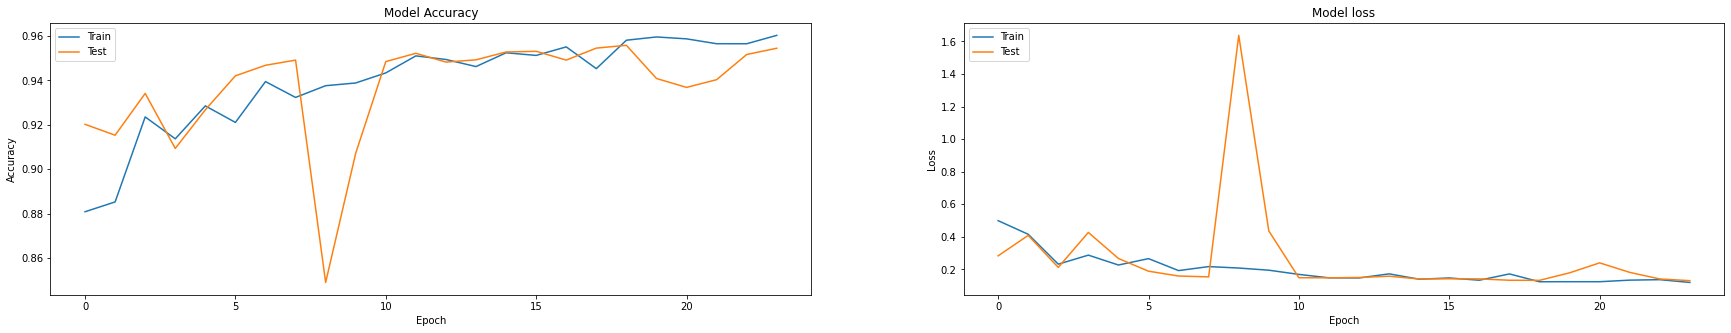

In [ ]:
# Plot training & validation acc values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model5.history.history['accuracy'])
plt.plot(model5.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model5.history.history['loss'])
plt.plot(model5.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [8]:
# Accuracy on training dataset

train_generator = datagen.flow_from_directory(
    "/OCT2017 /train",
    target_size = (224, 224),
    batch_size=32,
    class_mode = "categorical",
    subset="training",
    shuffle = False)

train_samples = 66788
batch_size = 32

result = model5.evaluate(train_generator, steps = train_samples // batch_size+1, verbose = 1)
print("Accuracy on Training Dataset:{0}, Loss on Test Dataset: {1}".format(result[1]*100,result[0]))

Found 66788 images belonging to 4 classes.
2088/2088 [==============================] - 797s 377ms/step - loss: 0.1551 - accuracy: 0.9479
Accuracy on Training Dataset:94.7894811630249, Loss on Test Dataset: 0.1550978124141693


In [ ]:
# Accuracy on test dataset

test_generator = datagen.flow_from_directory(
    "/content/OCT2017 /test",
    target_size = (224, 224),
    batch_size=128,
    class_mode = "categorical",
    shuffle = False)
test_samples = 968
batch_size = 128

result = model5.evaluate(test_generator, steps = test_samples // batch_size+1, verbose = 1)
print("Accuracy on Test Dataset:{0}, Loss on Test Dataset: {1}".format(result[1]*100,result[0]))

Found 968 images belonging to 4 classes.
8/8 [==============================] - 14s 1s/step - loss: 0.0711 - accuracy: 0.9845
Accuracy on Test Dataset:98.45041036605835, Loss on Test Dataset: 0.07112277299165726


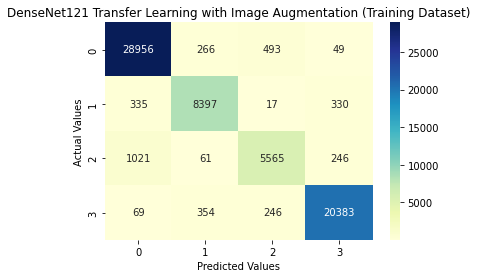

In [10]:
# Plot Confusion Matrix for Training Dataset

# predicted values
y_pred = model5.predict(train_generator, train_samples // batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusionmatrix = confusion_matrix(train_generator.classes,predicted_values)
plt.title("DenseNet121 Transfer Learning with Image Augmentation (Training Dataset)")
sns.heatmap(confusionmatrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

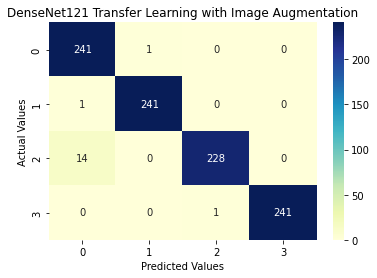

In [11]:
# Plot Confusion Matrix

# predicted values
y_pred = model5.predict(test_generator, test_samples // batch_size+1)
predicted_values = np.argmax(y_pred, axis=1)

confusionmatrix = confusion_matrix(test_generator.classes,predicted_values)
plt.title("DenseNet121 Transfer Learning with Image Augmentation")
sns.heatmap(confusionmatrix, annot=True, cmap="YlGnBu", fmt='g')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.show()

**Observations**

We are getting an accuracy of 0.98 on the test dataset using DenseNet121 Transfer Learning Model with Image Augmentation.